In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict
from PIL import Image
import numpy as np
from tabulate import tabulate
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import os
import torch.nn.functional as F

In [13]:
# === CONFIG ===
DATASET_PATH = r"F:\animals" # Path to your dataset
TARGET_SIZE = (64, 64)  # Reduced image size for better training stability
CLASS_LABELS = ["elephant", "dog", "spider"]
# === GAN CONFIG ===
LATENT_DIM = 100
BATCH_SIZE = 32  # Reduced batch size for more stable updates
NUM_EPOCHS = 250  # Increased epochs
LEARNING_RATE_D = 0.0002  # Separate learning rates
LEARNING_RATE_G = 0.0002
BETA1 = 0.5  # Standard beta1 value for GANs
BETA2 = 0.999
IMAGE_SIZE = TARGET_SIZE[0]  # Assuming square images

# Define the target class index
TARGET_CLASS = "elephant"
TARGET_CLASS_INDEX = CLASS_LABELS.index(TARGET_CLASS)

In [14]:
# === COUNT FILES ===
def count_images_per_class(dataset_path, class_labels):
    class_counts = {}
    for class_name in class_labels:
        class_path = os.path.join(dataset_path, class_name)
        if not os.path.exists(class_path):
            print(f"Warning: Class folder '{class_path}' does not exist.")
            continue
        count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        class_counts[class_name] = count
    return class_counts

In [15]:
# === GATHER IMAGE SIZES (OPTIONAL) ===
def get_image_sizes(dataset_path, class_labels, sample_size=50):
    sizes = defaultdict(list)
    for label in class_labels:
        class_path = os.path.join(dataset_path, label)
        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))][:sample_size]
        for img_file in image_files:
            try:
                with Image.open(os.path.join(class_path, img_file)) as img:
                    sizes[label].append(img.size)
            except:
                pass
    return sizes

# === PLOT FUNCTIONS ===
def plot_bar_chart(class_counts):
    df_plot = pd.DataFrame({
        'Class': list(class_counts.keys()),
        'Count': list(class_counts.values())
    })
    plt.figure(figsize=(8, 6))
    sns.barplot(data=df_plot, x="Class", y="Count", palette="pastel", legend=False)
    plt.title("Image Count per Class", fontsize=14)
    plt.xlabel("Art Style")
    plt.ylabel("Number of Images")
    for i, v in enumerate(df_plot["Count"]):
        plt.text(i, v + 20, str(v), ha='center')
    plt.tight_layout()
    plt.show()


def plot_pie_chart(class_counts):
    plt.figure(figsize=(7, 7))
    plt.pie(class_counts.values(), labels=class_counts.keys(), autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
    plt.title("Class Distribution")
    plt.tight_layout()
    plt.show()

def plot_image_size_distribution(image_sizes):
    plt.figure(figsize=(10, 6))
    for label, sizes in image_sizes.items():
        widths, heights = zip(*sizes)
        sns.kdeplot(widths, label=f'{label} width')
        sns.kdeplot(heights, label=f'{label} height')
    plt.title("Image Size Distribution by Class")
    plt.xlabel("Pixels")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

📊 Analyzing dataset...

📋 Dataset Summary:

          # of Images  Percentage
elephant         1446   12.991914
dog              4863   43.692722
spider           4821   43.315364


C:\Users\Joud\AppData\Local\Temp\ipykernel_17424\3405360296.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x="Class", y="Count", palette="pastel", legend=False)


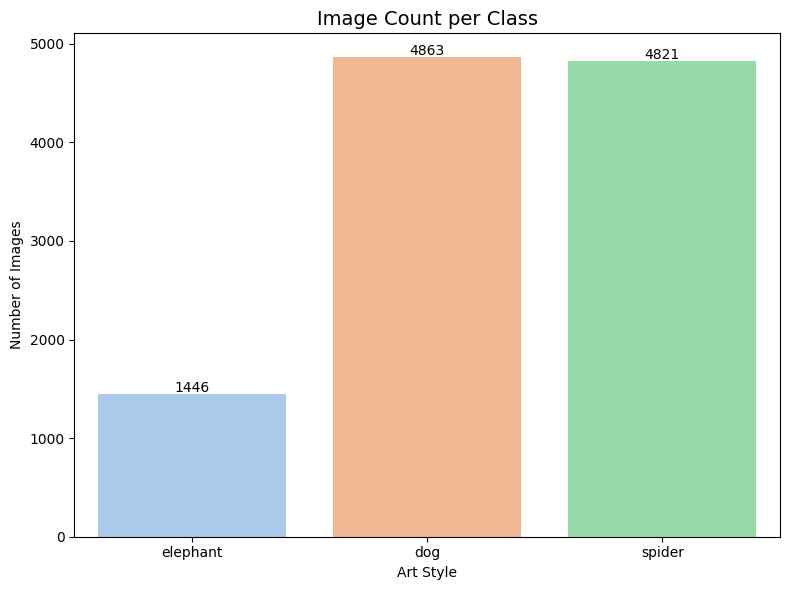

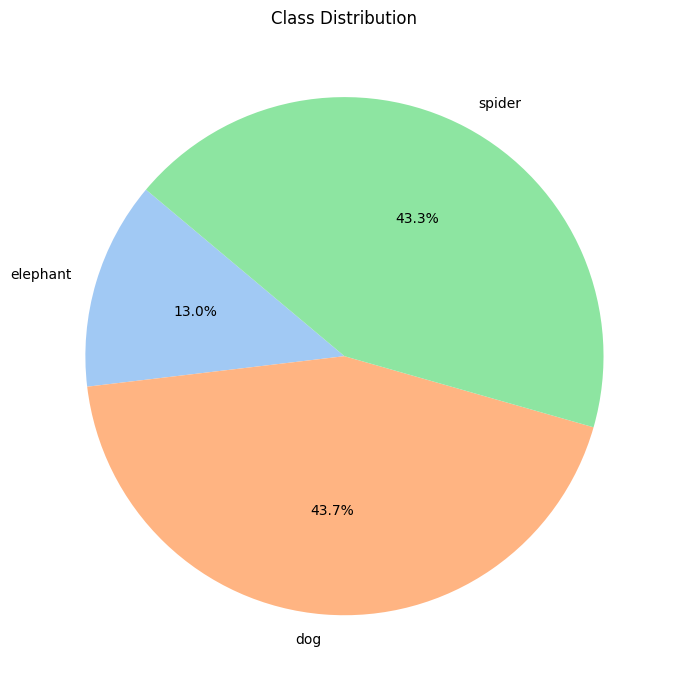


📏 Sampling image dimensions...


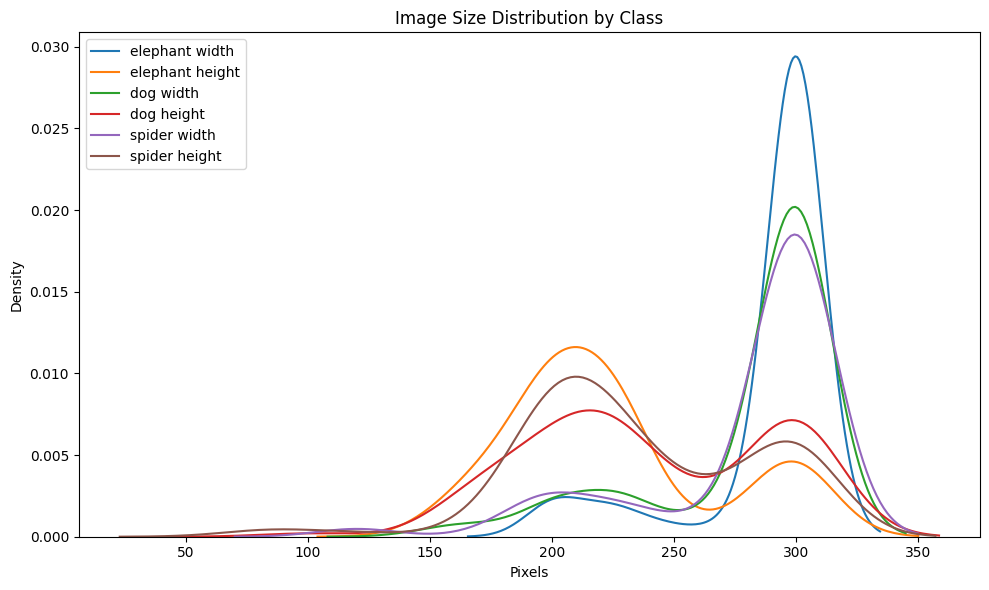

In [16]:
# === MAIN EXECUTION ===
if __name__ == "__main__":
    print("📊 Analyzing dataset...")
    
    # Count images
    class_counts = count_images_per_class(DATASET_PATH, CLASS_LABELS)
    
    # Print summary table
    df_summary = pd.DataFrame.from_dict(class_counts, orient='index', columns=["# of Images"])
    df_summary["Percentage"] = (df_summary["# of Images"] / df_summary["# of Images"].sum()) * 100
    print("\n📋 Dataset Summary:\n")
    print(df_summary.to_string())

    # Plot charts
    plot_bar_chart(class_counts)
    plot_pie_chart(class_counts)

    # Optional: Analyze image sizes
    print("\n📏 Sampling image dimensions...")
    image_sizes = get_image_sizes(DATASET_PATH, CLASS_LABELS, sample_size=100)
    plot_image_size_distribution(image_sizes)

In [17]:
# === DATA PREPROCESSING ===
transform = transforms.Compose([
    transforms.Resize(TARGET_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),  # Data augmentation
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),  # More augmentation
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Load the dataset, filtering for the target class
dataset = datasets.ImageFolder(root=DATASET_PATH, transform=transform)

# Filter dataset to only include images from the target class
target_indices = [i for i, (img_path, label) in enumerate(dataset.imgs) if label == TARGET_CLASS_INDEX]
target_dataset = torch.utils.data.Subset(dataset, target_indices)

dataloader = DataLoader(target_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)

In [18]:
# === IMPROVED GENERATOR MODEL ===
class Generator(nn.Module):
    def __init__(self, latent_dim, img_channels=3):
        super().__init__()

        # Starting size
        self.init_size = IMAGE_SIZE // 4  # We'll upsample 2 times (4x total)

        # Linear layer to project latent vector
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 128 * self.init_size * self.init_size),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # Convolutional layers with upsampling
        self.conv_blocks = nn.Sequential(
            # First block
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            # Second block
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            # Final layer to get 3 channels
            nn.Conv2d(64, img_channels, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        # Project and reshape
        out = self.linear(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        # Apply convolution blocks
        img = self.conv_blocks(out)
        return img

# === IMPROVED DISCRIMINATOR MODEL ===
class Discriminator(nn.Module):
    def __init__(self, img_channels=3):
        super().__init__()

        # Convolutional feature extraction
        self.conv_layers = nn.Sequential(
            # First layer - no BatchNorm
            nn.Conv2d(img_channels, 32, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),

            # Second layer
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),

            # Third layer
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),

            # Fourth layer
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
        )

        # Calculate the size after convolutions
        ds_size = IMAGE_SIZE // 2**4  # After 4 layers with stride 2

        # Fully connected layer
        self.fc = nn.Linear(256 * ds_size * ds_size, 1)

    def forward(self, img):
        features = self.conv_layers(img)
        features = features.view(features.size(0), -1)
        validity = self.fc(features)
        return torch.sigmoid(validity)

# === WEIGHTS INITIALIZATION FUNCTION ===
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find("Linear") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

# === INITIALIZE MODELS AND OPTIMIZERS ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

generator = Generator(LATENT_DIM).to(device)
discriminator = Discriminator().to(device)

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Use separate optimizers with different learning rates
optimizer_G = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE_G, betas=(BETA1, BETA2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=LEARNING_RATE_D, betas=(BETA1, BETA2))

# Use BCE loss with logits for numerical stability
adversarial_loss = nn.BCELoss()

# === SAMPLE FIXED NOISE FOR EVALUATION ===
# We'll use this to see consistent progress
fixed_noise = torch.randn(16, LATENT_DIM, device=device)

Using device: cpu


In [19]:
# Create the directory for saving generated images
save_dir = r"C:\Users\Joud\Documents\uni\fourth year\second semester\Special Topics in AI\Project\Animals 10\finalvanillaGAN"
os.makedirs(save_dir, exist_ok=True)
print(f"Generated images will be saved to: {save_dir}")

Generated images will be saved to: C:\Users\Joud\Documents\uni\fourth year\second semester\Special Topics in AI\Project\Animals 10\finalvanillaGAN


In [22]:
# === TRAINING LOOP ===
print("\nStarting training...")

# For tracking losses
g_losses = []
d_losses = []

# Define labels
real_label = 1.0
fake_label = 0.0

for epoch in range(NUM_EPOCHS):
    epoch_g_loss = 0.0
    epoch_d_loss = 0.0
    batches_done = 0

    for i, (imgs, _) in enumerate(dataloader):

        # Move to device
        real_imgs = imgs.to(device)
        batch_size = real_imgs.size(0)

        # -----------------
        #  Train Discriminator
        # -----------------

        optimizer_D.zero_grad()

        # Prepare labels
        real_labels = torch.full((batch_size, 1), real_label, device=device)
        fake_labels = torch.full((batch_size, 1), fake_label, device=device)

        # Add some noise to the labels for more robust training
        if epoch > 50:  # Start label smoothing after some epochs
            real_labels = real_labels - 0.1 * torch.rand(real_labels.shape, device=device)
            fake_labels = fake_labels + 0.1 * torch.rand(fake_labels.shape, device=device)

        # Loss on real images
        real_pred = discriminator(real_imgs)
        d_real_loss = adversarial_loss(real_pred, real_labels)

        # Loss on fake images
        z = torch.randn(batch_size, LATENT_DIM, device=device)
        fake_imgs = generator(z)
        fake_pred = discriminator(fake_imgs.detach())
        d_fake_loss = adversarial_loss(fake_pred, fake_labels)

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Generate fake images again (needed because we detached earlier)
        z = torch.randn(batch_size, LATENT_DIM, device=device)
        fake_imgs = generator(z)

        # Adversarial loss
        fake_pred = discriminator(fake_imgs)
        g_loss = adversarial_loss(fake_pred, real_labels)

        g_loss.backward()
        optimizer_G.step()

        # Record losses
        epoch_g_loss += g_loss.item()
        epoch_d_loss += d_loss.item()
        batches_done += 1

        # Print progress
        if (i+1) % 10 == 0:
            print(f"[Epoch {epoch+1}/{NUM_EPOCHS}] [Batch {i+1}/{len(dataloader)}] "
                  f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

    # Save average losses for this epoch
    g_losses.append(epoch_g_loss / batches_done)
    d_losses.append(epoch_d_loss / batches_done)

    # Save generated images periodically
    if (epoch + 1) % 10 == 0 or epoch == 0:
        with torch.no_grad():
            # Generate images from fixed noise
            gen_imgs = generator(fixed_noise).detach().cpu()

            # Denormalize
            gen_imgs = (gen_imgs + 1) / 2

            # Save as grid
            grid = torchvision.utils.make_grid(gen_imgs, nrow=4, normalize=False, padding=2)
            plt.figure(figsize=(10, 10))
            plt.imshow(grid.permute(1, 2, 0))
            plt.axis('off')
            plt.savefig(f"{save_dir}/epoch_{epoch+1}.png")
            plt.close()

            print(f"Saved images for epoch {epoch+1}")


Starting training...
[Epoch 1/250] [Batch 10/152] [D loss: 0.6878] [G loss: 0.6916]
[Epoch 1/250] [Batch 20/152] [D loss: 0.6983] [G loss: 0.6452]
[Epoch 1/250] [Batch 30/152] [D loss: 0.7587] [G loss: 0.8965]
[Epoch 1/250] [Batch 40/152] [D loss: 0.6976] [G loss: 0.9015]
[Epoch 1/250] [Batch 50/152] [D loss: 0.6765] [G loss: 0.6966]
[Epoch 1/250] [Batch 60/152] [D loss: 0.6797] [G loss: 0.7684]
[Epoch 1/250] [Batch 70/152] [D loss: 0.7686] [G loss: 0.8309]
[Epoch 1/250] [Batch 80/152] [D loss: 0.7505] [G loss: 0.8030]
[Epoch 1/250] [Batch 90/152] [D loss: 0.6813] [G loss: 0.6395]
[Epoch 1/250] [Batch 100/152] [D loss: 0.8236] [G loss: 0.7516]
[Epoch 1/250] [Batch 110/152] [D loss: 0.7448] [G loss: 0.6941]
[Epoch 1/250] [Batch 120/152] [D loss: 0.6726] [G loss: 0.6079]
[Epoch 1/250] [Batch 130/152] [D loss: 0.7335] [G loss: 0.7838]
[Epoch 1/250] [Batch 140/152] [D loss: 0.7204] [G loss: 0.7255]
[Epoch 1/250] [Batch 150/152] [D loss: 0.8190] [G loss: 0.6208]
Saved images for epoch 1
[E

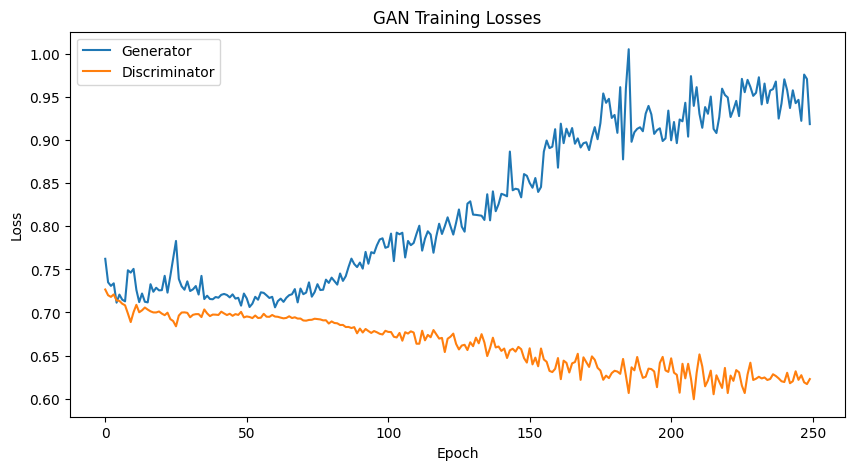

In [23]:
# Plot the training losses
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label="Generator")
plt.plot(d_losses, label="Discriminator")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("GAN Training Losses")
plt.savefig(f"{save_dir}/training_losses.png")
plt.show()


Generating final set of images...


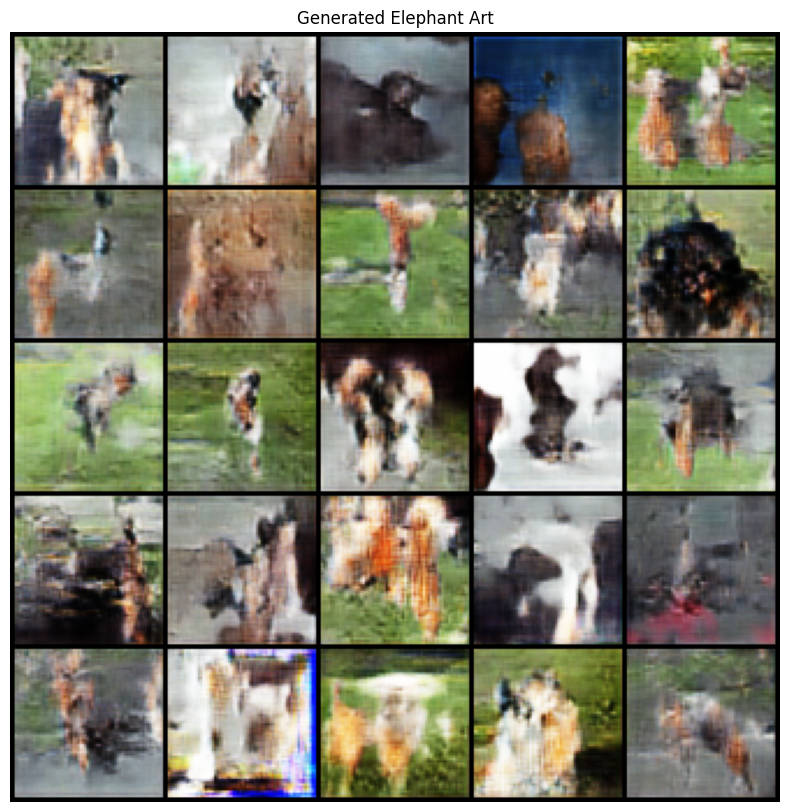


Training finished!
Generated images saved to C:\Users\Joud\Documents\uni\fourth year\second semester\Special Topics in AI\Project\Animals 10\finalvanillaGAN


In [24]:
# Generate a final batch of images
print("\nGenerating final set of images...")
with torch.no_grad():
    z = torch.randn(25, LATENT_DIM, device=device)
    generated_images = generator(z).detach().cpu()
    generated_images = (generated_images + 1) / 2  # Denormalize

    grid_img = torchvision.utils.make_grid(generated_images, nrow=5, padding=2)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.title(f"Generated {TARGET_CLASS.replace('_', ' ').title()} Art")
    plt.axis('off')
    plt.savefig(f"{save_dir}/final_images.png")
    plt.show()

print("\nTraining finished!")
print(f"Generated images saved to {save_dir}")

In [25]:
# Save models
torch.save(generator.state_dict(), f"{save_dir}/generator.pth")
torch.save(discriminator.state_dict(), f"{save_dir}/discriminator.pth")
print("Models saved successfully")

Models saved successfully


In [26]:

import os
from torchvision.utils import save_image

# === GENERATE SYNTHETIC IMAGES TO BALANCE DATASET ===

# Count images per class
class_counts = {label: len(os.listdir(os.path.join(DATASET_PATH, label))) 
                 for label in CLASS_LABELS}

# Find minority class and target number
min_class = min(class_counts, key=class_counts.get)
max_count = max(class_counts.values())
needed = max_count - class_counts[min_class]

print(f"Minority class: {min_class}, Generating {needed} synthetic images to balance.")

# Prepare output directory
balanced_dir = os.path.join(DATASET_PATH, f"balanced_{min_class}")
os.makedirs(balanced_dir, exist_ok=True)

# Generate images using the trained generator
generator.eval()
z_dim = 100  # must match training config
batch_size = 32
generated = 0

with torch.no_grad():
    while generated < needed:
        gen_batch = min(batch_size, needed - generated)
        z = torch.randn(gen_batch, z_dim).to(device)
        fake_imgs = generator(z)
        fake_imgs = (fake_imgs + 1) / 2  # denormalize

        for i in range(gen_batch):
            save_path = os.path.join(balanced_dir, f"fake_{generated + i + 1}.png")
            save_image(fake_imgs[i], save_path)

        generated += gen_batch

print(f"Saved {generated} synthetic images to '{balanced_dir}'")


Minority class: elephant, Generating 3417 synthetic images to balance.
Saved 3417 synthetic images to 'F:\animals\balanced_elephant'
